# Notebook for the calculation of the equilibrium frequency from the experimental data

In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

sns.set()

### Loading of dataset and setting of some variables

In [2]:
X_plot = np.linspace(0, 1, 100)

In [3]:
transferexp = pd.read_csv('data/Supplemental_data_data_coex.csv')
transferexp['abs_diff_with_next'] = np.abs(transferexp['Ratio_startcycle'] - transferexp['Ratio'])
transferexp['diff_with_next'] = transferexp['Ratio_startcycle'] - transferexp['Ratio']

In [4]:
transferexp.head()

,Time,Initial_ratio_Triple,Treatment,Replicate,Ratio_startcycle,Triple,G238S,Ratio,CTX,Unique_code,abs_diff_with_next,diff_with_next
0,0,0.1,0.2,1,0.1,NaN,NaN,0.1,12.5,0.1_12.5_T0_Repl1,0.0,0.0
1,0,0.1,0.2,2,0.1,NaN,NaN,0.1,12.5,0.1_12.5_T0_Repl2,0.0,0.0
2,0,0.1,0.2,3,0.1,NaN,NaN,0.1,12.5,0.1_12.5_T0_Repl3,0.0,0.0
3,0,0.1,0.2,4,0.1,NaN,NaN,0.1,12.5,0.1_12.5_T0_Repl4,0.0,0.0
4,0,0.1,0.2,5,0.1,NaN,NaN,0.1,12.5,0.1_12.5_T0_Repl5,0.0,0.0


In [5]:
transferexp['CTX'].unique()

array([12.5, 25. , 50. ])

In [6]:
transferexp['Treatment'].unique()

array([0.2 , 0.43, 0.93, 2.  ])

Create subsets for only one antibiotic concentration (CTX) or only one glycerol concentration (Treatment) for making plots and sub analysis. Timepoint 0 is removed because that is before the first transfer, so there is no start and end ratio for that one.

In [7]:
transferexp12 = transferexp[(transferexp['CTX']==12.5) & (transferexp['Time'] != 0)]
transferexp25 = transferexp[(transferexp['CTX']==25.) & (transferexp['Time'] != 0)]
transferexp50 = transferexp[(transferexp['CTX']==50.) & (transferexp['Time'] != 0)]
transferexp2 = transferexp[(transferexp['Treatment']==2) & (transferexp['Time'] != 0)]
transferexp093 = transferexp[(transferexp['Treatment']==0.93) & (transferexp['Time'] != 0)]
transferexp043 = transferexp[(transferexp['Treatment']==0.43) & (transferexp['Time'] != 0)]
transferexp02 = transferexp[(transferexp['Treatment']==0.2) & (transferexp['Time'] != 0)]

In [8]:
transferexp12.head()

,Time,Initial_ratio_Triple,Treatment,Replicate,Ratio_startcycle,Triple,G238S,Ratio,CTX,Unique_code,abs_diff_with_next,diff_with_next
96,48,0.1,0.2,1,0.1,335000000.0,35800000.0,0.903561,12.5,0.1_12.5_T48_Repl1,0.803561,-0.803561
97,48,0.1,0.2,2,0.1,275000000.0,82400000.0,0.769416,12.5,0.1_12.5_T48_Repl2,0.669416,-0.669416
98,48,0.1,0.2,3,0.1,246000000.0,105000000.0,0.701220,12.5,0.1_12.5_T48_Repl3,0.601220,-0.601220
99,48,0.1,0.2,4,0.1,293000000.0,68800000.0,0.809913,12.5,0.1_12.5_T48_Repl4,0.709913,-0.709913
100,48,0.1,0.2,5,0.1,342000000.0,32900000.0,0.912299,12.5,0.1_12.5_T48_Repl5,0.812299,-0.812299


### Function to calcuate the equilibrium ration (crossing of the diagonal)

The function cross_diag takes as input a dateframe with one experiment (one glycerol concentration, one antibiotic concentration and one replica) and does the following operations to calculate the equilibrium frequency:
1. The dataframe is sorted by the initial frequency of TEM-52 (the most resistent strain)
2. A list of pairs [initial frequency, final frequency] is created
3. For every item (except the last) in the list the difference of initial frequency with the next initial frequency is calculated
4. Similarly, the difference of the final frequency with the next final frequency is calculated
5. If these are unequal (otherwise the diagonal cannot be crossed and this would otherwise lead to division by 0), the difference of the final and initial ratio is divided by the change in the final ration minus the change in the initial ratio ( (saved as t) => this can be seen as moving from the first pair in the direction of the second pair, where t gives how far to move in that direction to reach the diagonal (as relative to the second pair, so t=1 would mean the second pair is exactly on the diagonal)
6. If t is between 1 and 0, this means the diagonal is crossed at the inital ratio plus t * the change in the initial ratio
7. the average of all crossings is returned

In [9]:
def cross_diag(df):
    df = df.sort_values('Ratio_startcycle')
    ta = np.array([[ratio1, ratio2] for ratio1, ratio2 in zip(df['Ratio_startcycle'], df['Ratio'])])
    crossings = []
    for i in range(0,len(ta)-1):
        deltax = (ta[i+1,0]-ta[i,0])
        deltay = ta[i+1,1]-ta[i,1]
        if deltay != deltax:
            t = (ta[i,0]-ta[i,1])/(deltay-deltax)
        else:
            t = 0
        if 0<t<1:
            crossings.append(ta[i,0]+t*deltax)
    return np.mean(crossings)

### Example of calculation of the equilibrium frequency for CTX=50 and a starting ratio of 0.1

In [19]:
selection_tr50_all = transferexp50[(transferexp50['Initial_ratio_Triple']==0.1)]

In [20]:
intersections_selection_tr50_all = selection_tr50_all.groupby(['CTX', 'Replicate', 'Treatment', 'Initial_ratio_Triple']).apply(cross_diag)
intersections_selection_tr50_all = [intersections_selection_tr50_all.loc[[i]].reset_index().values.tolist()[0] for i in intersections_selection_tr50_all.index]

C:\Users\meike\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\meike\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [21]:
max1 = len(intersections_selection_tr50_all)

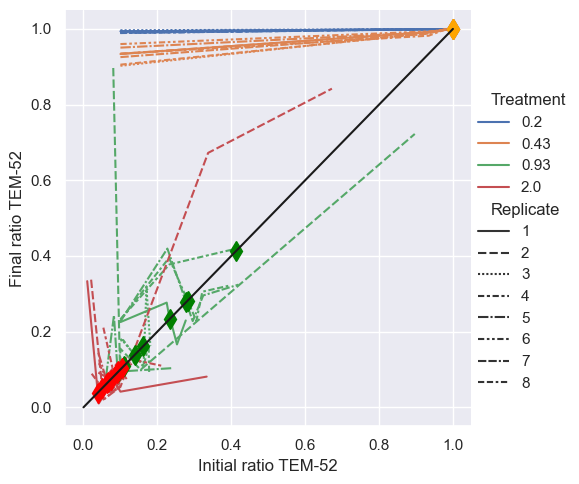

In [27]:
sns.relplot(data=selection_tr50_all, x="Ratio_startcycle", y="Ratio", hue='Treatment', kind='line', palette="deep", style='Replicate', aspect=1)

X_plot = np.linspace(0, 1, 100)

for i in range(0,max1, 4):
    plt.plot(intersections_selection_tr50_all[i][4],intersections_selection_tr50_all[i][4], marker="d", markersize=10, markeredgecolor="blue", markerfacecolor="blue")
for i in range(1,max1, 4):
    plt.plot(intersections_selection_tr50_all[i][4],intersections_selection_tr50_all[i][4], marker="d", markersize=10, markeredgecolor="orange", markerfacecolor="orange")
for i in range(2,max1, 4):
    plt.plot(intersections_selection_tr50_all[i][4],intersections_selection_tr50_all[i][4], marker="d", markersize=10, markeredgecolor="green", markerfacecolor="green")
for i in range(3,max1, 4):
    plt.plot(intersections_selection_tr50_all[i][4],intersections_selection_tr50_all[i][4], marker="d", markersize=10, markeredgecolor="red", markerfacecolor="red")

plt.plot(X_plot,X_plot, c='k')

plt.xlabel('Initial ratio TEM-52')
plt.ylabel('Final ratio TEM-52')

plt.savefig('Example_eqratio.png')

plt.show()

### Calculate the equilibrium frequency for all experiments

In [28]:
diag_cross_groups_all = transferexp.groupby(['CTX', 'Replicate', 'Treatment', 'Initial_ratio_Triple']).apply(cross_diag)

C:\Users\meike\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\meike\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [29]:
diag_cross_groups_all.reset_index()

,CTX,Replicate,Treatment,Initial_ratio_Triple,0
0,12.5,1,0.20,0.1,0.999955
1,12.5,1,0.20,0.5,0.065918
2,12.5,1,0.20,0.9,0.090967
3,12.5,1,0.43,0.1,NaN
4,12.5,1,0.43,0.5,NaN
...,...,...,...,...,...
283,50.0,8,0.93,0.5,0.444606
284,50.0,8,0.93,0.9,0.943178
285,50.0,8,2.00,0.1,0.094687
286,50.0,8,2.00,0.5,0.476964


In [31]:
#diag_cross_groups_all.reset_index().to_csv('equilibrium_freq_experimental.csv', index=False)  

### Plotting contourplot from best model estimates determined in R

In [16]:
CTX = np.linspace(12.5,50, num= 1000)
Trt = np.linspace(0.2,2, num= 1000) 

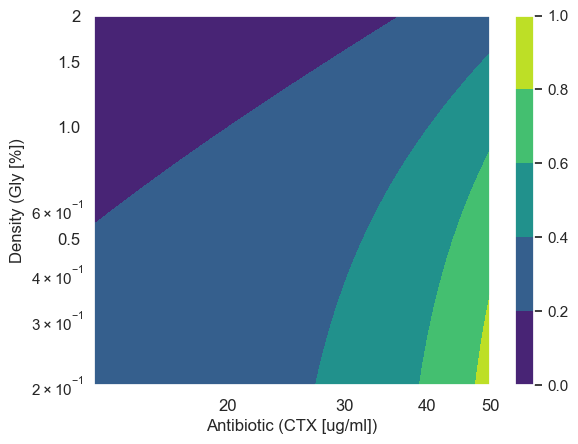

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
X, Y = np.meshgrid(CTX, Trt)

Z =  np.exp(-0.563124*Y +0.034151*X -1.730354 ) #best model GLMM replicate random factor

Z[Z > 1] = 1
Z[Z < 0] = 0
#Z=np.array(Z_new)µ
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z, levels=3,cmap=cm.viridis)
fig.colorbar(cp) # Add a colorbar to a plot
plt.yscale('log')
plt.xscale('log')
ax.set_xlabel('Antibiotic (CTX [ug/ml])')
ax.set_ylabel('Density (Gly [%])')
ax.set_xticks([20,30,40,50]) 
ax.set_xticklabels([20,30,40,50], fontsize=12)
ax.set_yticks([0.5,1.0,1.5,2]) 
ax.set_yticklabels([0.5,1.0,1.5,2], fontsize=12)
plt.savefig("eqq.pdf", format="pdf", bbox_inches="tight")
plt.show()